<a href="https://colab.research.google.com/github/fareesah28/INM705-CW/blob/main/MariumColabFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Extraction

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/data_trimmed_clean.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data_trimmed/Train/Shooting/Shooting042_x264_1030.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting020_x264_2680.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting029_x264_1260.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting009_x264_2690.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting014_x264_2740.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting006_x264_4510.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting006_x264_11010.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting006_x264_9020.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting005_x264_1860.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting052_x264_4560.png  
  inflating: /content/data_trimmed/Train/Shooting/Shooting009_x264_130.png  
 extracting: /content/data_trimmed/Train/Shooting/Shooting027_x264_140.png  
  inflating: /

Data Reconstructing

In [4]:
import os
import shutil
from collections import defaultdict

def extract_video_id(filename):
    """
    Extracts the video ID by removing the frame suffix (assumes last underscore + digits is the frame number).
    For example:
        Normal_Videos_003_x264_0.png → Normal_Videos_003_x264
        Assault_001_frame_010.png → Assault_001
    """
    parts = filename.rsplit("_", 1)
    return parts[0] if len(parts) == 2 else filename.split("_frame")[0]

def restructure_dataset(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)

    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_name}")
        video_frame_dict = defaultdict(list)

        for fname in os.listdir(class_path):
            if not fname.endswith('.png'):
                continue

            video_id = extract_video_id(fname)
            video_frame_dict[video_id].append(fname)

        for video_id, frames in video_frame_dict.items():
            video_folder_path = os.path.join(dst_dir, class_name, video_id)
            os.makedirs(video_folder_path, exist_ok=True)

            for frame in frames:
                src = os.path.join(class_path, frame)
                dst = os.path.join(video_folder_path, frame)
                shutil.copy2(src, dst)

    print(f"Done restructuring: {src_dir} → {dst_dir}\n")

train_dir = "/content/data_trimmed/Train"
test_dir = "/content/data_trimmed/Test"

train_dst = "/content/data_trimmed_restructured/Train"
test_dst = "/content/data_trimmed_restructured/Test"

# Run restructuring
restructure_dataset(train_dir, train_dst)
restructure_dataset(test_dir, test_dst)

Processing class: Shooting
Processing class: Arrest
Processing class: Explosion
Processing class: Fighting
Processing class: NormalVideos
Processing class: Assault
Processing class: Burglary
Processing class: Arson
Done restructuring: /content/data_trimmed/Train → /content/data_trimmed_restructured/Train

Processing class: Shooting
Processing class: Arrest
Processing class: Explosion
Processing class: Fighting
Processing class: NormalVideos
Processing class: Assault
Processing class: Burglary
Processing class: Arson
Done restructuring: /content/data_trimmed/Test → /content/data_trimmed_restructured/Test



# Pad  video to 16 frames , stack into a (16, 64, 64, 3) array

In [5]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
SEQUENCE_LENGTH = 16
BATCH_SIZE = 8
CLASS_NAMES = ['Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','Shooting']
NUM_CLASSES = len(CLASS_NAMES)

# one sequence of frames for each video folder


In [6]:
import tensorflow as tf
import numpy as np
import os
from glob import glob
from tensorflow.keras.utils import to_categorical
from PIL import Image

def load_video_frames(video_dir, sequence_length, img_size):
    # Get sorted list of frame paths
    frame_paths = sorted(glob(os.path.join(video_dir, "*.png")))

    frames = []
    for path in frame_paths[:sequence_length]:
        img = Image.open(path).resize(img_size)
        frame = np.array(img).astype("float32") / 255.0  # Normalize to [0, 1]
        frames.append(frame)


    while len(frames) < sequence_length:
        frames.append(np.zeros((img_size[1], img_size[0], 3), dtype="float32"))

    return np.stack(frames)

def get_video_paths_and_labels(base_dir, class_names):
    video_paths = []
    labels = []

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(base_dir, class_name)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            if os.path.isdir(video_path):
                video_paths.append(video_path)
                labels.append(class_index)

    return video_paths, labels

def build_video_dataset(base_dir, sequence_length, img_size, batch_size, class_names, shuffle=True):
    video_paths, labels = get_video_paths_and_labels(base_dir, class_names)

    def generator():
        for video_path, label in zip(video_paths, labels):
            frames = load_video_frames(video_path, sequence_length, img_size)
            yield frames, to_categorical(label, num_classes=len(class_names))

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length, img_size[1], img_size[0], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(len(class_names),), dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(video_paths))

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
train_dir = "data_trimmed_restructured/Train"
test_dir = "data_trimmed_restructured/Test"
train_dataset = build_video_dataset(
    base_dir=train_dir,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    shuffle=True
)

test_dataset = build_video_dataset(
    base_dir=test_dir,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    shuffle=False
)

In [8]:
for x, y in train_dataset.take(1):
    print(x.shape)  # (8, 16, 64, 64, 3)
    print(y.shape)  # (8, 8)

(8, 16, 64, 64, 3)
(8, 8)


DINOv2 + Transformer Model - Basic

In [9]:
!pip install transformers


DINOv2 + Transformer model - Basic

In [10]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
dinov2.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [12]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length, img_size, class_names):
        self.video_paths = video_paths
        self.labels = labels
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.class_names = class_names

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        frame_paths = sorted([
            os.path.join(video_path, f)
            for f in os.listdir(video_path)
            if f.endswith(".png")
        ])

        frames = []
        for path in frame_paths[:self.sequence_length]:
            img = Image.open(path).resize(self.img_size)
            inputs = processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                features = dinov2(**inputs).last_hidden_state.mean(dim=1).squeeze(0)
            frames.append(features)

        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))

        sequence = torch.stack(frames)
        return sequence, torch.tensor(label, dtype=torch.long)


In [13]:
class VideoTransformerClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout=0.3):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=2
        )

        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)


In [14]:

train_video_paths, train_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Train", CLASS_NAMES)
test_video_paths, test_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Test", CLASS_NAMES)

#  class weights from training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

#  datasets and loaders
train_dataset = VideoDataset(train_video_paths, train_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES)
test_dataset = VideoDataset(test_video_paths, test_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [15]:
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)

        # weighted cross-entropy
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    try:
        train_auc = roc_auc_score(
            F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )
    except:
        train_auc = 0.0

    # evaluate on test
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)

            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    try:
        test_auc = roc_auc_score(
            F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )
    except:
        test_auc = 0.0

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train Loss: 2.1575, Acc: 0.2369, AUC: 0.5449 | Test Loss: 2.0023, Acc: 0.2000, AUC: 0.5269
Epoch 02 | Train Loss: 1.7052, Acc: 0.4286, AUC: 0.6512 | Test Loss: 2.2424, Acc: 0.2154, AUC: 0.5160
Epoch 03 | Train Loss: 1.4237, Acc: 0.5017, AUC: 0.6994 | Test Loss: 1.8042, Acc: 0.3846, AUC: 0.6108
Epoch 04 | Train Loss: 1.0220, Acc: 0.6655, AUC: 0.8015 | Test Loss: 2.0548, Acc: 0.3692, AUC: 0.6129
Epoch 05 | Train Loss: 0.8521, Acc: 0.7143, AUC: 0.8372 | Test Loss: 2.1088, Acc: 0.3538, AUC: 0.5993
Epoch 06 | Train Loss: 0.5493, Acc: 0.8223, AUC: 0.8960 | Test Loss: 2.3479, Acc: 0.4000, AUC: 0.6214
Epoch 07 | Train Loss: 0.4334, Acc: 0.8641, AUC: 0.9206 | Test Loss: 2.4955, Acc: 0.3846, AUC: 0.6189
Epoch 08 | Train Loss: 0.3686, Acc: 0.8780, AUC: 0.9295 | Test Loss: 2.1876, Acc: 0.4308, AUC: 0.6446
Epoch 09 | Train Loss: 0.2532, Acc: 0.9199, AUC: 0.9613 | Test Loss: 2.8557, Acc: 0.4000, AUC: 0.6367
Epoch 10 | Train Loss: 0.1473, Acc: 0.9617, AUC: 0.9787 | Test Loss: 3.0406, Acc: 

**summary of the basic model performance**



Good :

*   training loss and accuracy are improving
*   test AUC is relatively stable


Bad :
*   test accuracy is stagnant
*   test Loss is increasing - overfitting
*   wide gap between training and test performance











Model Fine - Tuning

In [16]:
# fine tuning block 1 - Imports and DINOv2 Setup (same as before)
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoImageProcessor, AutoModel
from PIL import Image, ImageEnhance
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import random


In [17]:
# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DINOv2 setup
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
dinov2.eval()


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [18]:
# fine-tuning block 2: dataset class with simple augmentations
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length, img_size, class_names, augment=False):
        self.video_paths = video_paths
        self.labels = labels
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.class_names = class_names
        self.augment = augment

    def augment_frame(self, image):
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.3:
            enhancer = ImageEnhance.Brightness(image)
            image = enhancer.enhance(random.uniform(0.7, 1.3))
        return image

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        frame_paths = sorted([
            os.path.join(video_path, f)
            for f in os.listdir(video_path)
            if f.endswith(".png")
        ])

        frames = []
        for path in frame_paths[:self.sequence_length]:
            img = Image.open(path).resize(self.img_size)
            if self.augment:
                img = self.augment_frame(img)
            inputs = processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                features = dinov2(**inputs).last_hidden_state.mean(dim=1).squeeze(0)
            frames.append(features)

        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))

        sequence = torch.stack(frames)
        return sequence, torch.tensor(label, dtype=torch.long)


In [19]:
# fine tuning block 3: updated model with more dropout and simplified classifier
class VideoTransformerClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout=0.4):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=2
        )

        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)

In [20]:
# fine tuning block 4: class weights + sampler
from collections import Counter

train_video_paths, train_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Train", CLASS_NAMES)
test_video_paths, test_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Test", CLASS_NAMES)

# class weights
class_weights = compute_class_weight('balanced', classes=np.arange(len(CLASS_NAMES)), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Sampler to balance classes in training
class_counts = Counter(train_labels)
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

#  sampler + augmentation for train only
train_dataset = VideoDataset(train_video_paths, train_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES, augment=True)
test_dataset = VideoDataset(test_video_paths, test_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES, augment=False)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [21]:
# fine tuning block  5: training loop with early stopping + metrics
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

best_test_auc = 0.0
patience, patience_counter = 3, 0  # early stopping

for epoch in range(1, 11):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    # validation
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

    # early stopping
    if test_auc > best_test_auc:
        best_test_auc = test_auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train Loss: 2.0203, Acc: 0.2056, AUC: 0.5401 | Test Loss: 2.2317, Acc: 0.1692, AUC: 0.5212
Epoch 02 | Train Loss: 1.6454, Acc: 0.3206, AUC: 0.6014 | Test Loss: 2.1190, Acc: 0.2154, AUC: 0.5405
Epoch 03 | Train Loss: 1.4885, Acc: 0.4355, AUC: 0.6816 | Test Loss: 2.0544, Acc: 0.2923, AUC: 0.6051
Epoch 04 | Train Loss: 1.3068, Acc: 0.5226, AUC: 0.7297 | Test Loss: 1.9400, Acc: 0.2923, AUC: 0.5956
Epoch 05 | Train Loss: 1.0534, Acc: 0.6098, AUC: 0.7786 | Test Loss: 2.0939, Acc: 0.3538, AUC: 0.6349
Epoch 06 | Train Loss: 0.8272, Acc: 0.6829, AUC: 0.8193 | Test Loss: 2.0885, Acc: 0.2769, AUC: 0.5839
Epoch 07 | Train Loss: 0.7236, Acc: 0.7038, AUC: 0.8338 | Test Loss: 1.9507, Acc: 0.3846, AUC: 0.6249
Epoch 08 | Train Loss: 0.6573, Acc: 0.7317, AUC: 0.8338 | Test Loss: 1.9447, Acc: 0.3692, AUC: 0.6224
Early stopping triggered.


further fine tuning

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[FT-Classifier] Epoch 01 | Train Loss: 0.8881, Acc: 0.6551, AUC: 0.8019 | Test Loss: 2.1824, Acc: 0.3385, AUC: 0.6191
[FT-Classifier] Epoch 02 | Train Loss: 0.7283, Acc: 0.7282, AUC: 0.8436 | Test Loss: 2.2597, Acc: 0.3385, AUC: 0.6188
[FT-Classifier] Epoch 03 | Train Loss: 0.6996, Acc: 0.7456, AUC: 0.8597 | Test Loss: 2.0776, Acc: 0.3231, AUC: 0.6005
[FT-Classifier] Epoch 04 | Train Loss: 0.6001, Acc: 0.7909, AUC: 0.8657 | Test Loss: 2.1959, Acc: 0.2923, AUC: 0.5872
Early stopping triggered on classifier fine-tune.


<Figure size 1000x800 with 0 Axes>

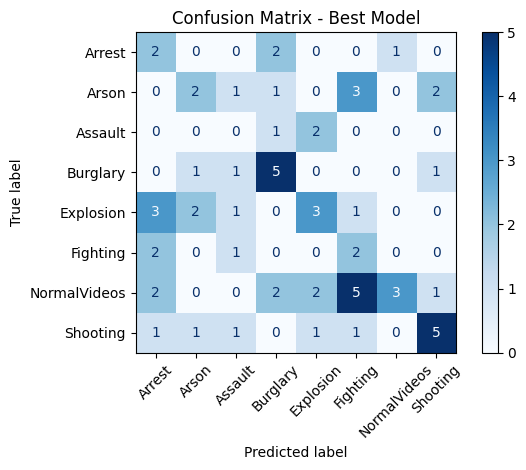

In [22]:


#  best saved model & freeze base layers
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
model.load_state_dict(torch.load("best_model.pt"))

# freeze all layers except classification head
for name, param in model.named_parameters():
    if 'cls_head' not in name:
        param.requires_grad = False

# : new optimizer for just the head
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# retrain classifier with same early stopping
best_test_auc = 0.0
patience, patience_counter = 3, 0

for epoch in range(1, 11):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    # eval
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    print(f"[FT-Classifier] Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

    if test_auc > best_test_auc:
        best_test_auc = test_auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_finetuned_head.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered on classifier fine-tune.")
            break

#  confusion matrix for final predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model_finetuned_head.pt"))
model.eval()
final_preds, final_targets = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        final_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        final_targets.extend(batch_y.numpy())

cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Best Model")
plt.tight_layout()
plt.show()


Grid Search

In [24]:

import itertools
import random
from copy import deepcopy
import pandas as pd

# hyperparameters
param_grid = {
    'sequence_length': [16, 32],
    'dropout': [0.3, 0.4],
    'hidden_dim': [128, 256],
    'num_layers': [1, 2],
    'lr': [1e-3, 1e-4]
}

# combintions
combinations = list(itertools.product(*param_grid.values()))
random.shuffle(combinations)  # fir diversity
combinations = combinations[:15]  #  15 configs
param_names = list(param_grid.keys())

#  logging metrics
logs = []
best_auc = 0
best_config = None

for i, combo in enumerate(combinations):
    config = dict(zip(param_names, combo))
    print(f"\n Config {i+1}/15: {config}")

    train_dataset.sequence_length = config['sequence_length']
    test_dataset.sequence_length = config['sequence_length']
    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    class GridVideoTransformer(nn.Module):
        def __init__(self, feature_dim, num_classes, sequence_length, dropout, hidden_dim, num_layers):
            super().__init__()
            self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=feature_dim,
                    nhead=4,
                    dim_feedforward=512,
                    dropout=dropout,
                    activation='gelu',
                    batch_first=True,
                    norm_first=True
                ),
                num_layers=num_layers
            )
            self.cls_head = nn.Sequential(
                nn.LayerNorm([sequence_length, feature_dim]),
                nn.Flatten(),
                nn.Dropout(dropout),
                nn.Linear(feature_dim * sequence_length, hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )

        def forward(self, x):
            x = x + self.positional_encoding[:, :x.size(1), :]
            x = self.transformer(x)
            return self.cls_head(x)

    model = GridVideoTransformer(
        feature_dim=768,
        num_classes=len(CLASS_NAMES),
        sequence_length=config['sequence_length'],
        dropout=config['dropout'],
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers']
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)

    for epoch in range(3):
        model.train()
        train_loss, train_preds, train_targets = 0, [], []

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(batch_y.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_auc = roc_auc_score(
            F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )

        model.eval()
        test_loss, test_preds, test_targets = 0, [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = F.cross_entropy(outputs, batch_y)
                test_loss += loss.item() * batch_x.size(0)
                test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                test_targets.extend(batch_y.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        test_acc = accuracy_score(test_targets, test_preds)
        test_auc = roc_auc_score(
            F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

        logs.append({
            **config,
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_auc': train_auc,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_auc': test_auc
        })

        if test_auc > best_auc:
            best_auc = test_auc
            best_config = deepcopy(config)
            torch.save(model.state_dict(), "best_grid_model.pt")

# saving
pd.DataFrame(logs).to_csv("grid_search_results.csv", index=False)
print("\n Best Config:", best_config)
print(f" Best AUC: {best_auc:.4f}")


 Config 1/15: {'sequence_length': 32, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0472, Acc: 0.2230, AUC: 0.5491 | Test Loss: 2.0790, Acc: 0.2154, AUC: 0.5367
[Epoch 2] Train Loss: 1.7088, Acc: 0.3415, AUC: 0.6117 | Test Loss: 1.9539, Acc: 0.2615, AUC: 0.5718
[Epoch 3] Train Loss: 1.5874, Acc: 0.3833, AUC: 0.6437 | Test Loss: 1.8909, Acc: 0.3231, AUC: 0.6159

 Config 2/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 1.9910, Acc: 0.2160, AUC: 0.5430 | Test Loss: 2.1141, Acc: 0.1692, AUC: 0.5162
[Epoch 2] Train Loss: 1.5770, Acc: 0.3902, AUC: 0.6371 | Test Loss: 2.0306, Acc: 0.2615, AUC: 0.5716
[Epoch 3] Train Loss: 1.2712, Acc: 0.5192, AUC: 0.7289 | Test Loss: 2.1489, Acc: 0.3231, AUC: 0.6333

 Config 3/15: {'sequence_length': 32, 'dropout': 0.4, 'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0492, Acc: 0.2230, AUC: 0.5487 | Test Loss: 2.1022, Acc: 0.2462, AUC: 0.5695
[Epoch 2] Train Loss: 1.7295, Acc: 0.3589, AUC: 0.6254 | Test Loss: 1.9407, Acc: 0.2769, AUC: 0.6054
[Epoch 3] Train Loss: 1.1244, Acc: 0.5366, AUC: 0.7324 | Test Loss: 1.8746, Acc: 0.2615, AUC: 0.5610

 Config 4/15: {'sequence_length': 32, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.1167, Acc: 0.2474, AUC: 0.5634 | Test Loss: 2.2275, Acc: 0.1231, AUC: 0.5120
[Epoch 2] Train Loss: 1.4862, Acc: 0.4251, AUC: 0.6716 | Test Loss: 1.8732, Acc: 0.2769, AUC: 0.5864
[Epoch 3] Train Loss: 1.0756, Acc: 0.5854, AUC: 0.7546 | Test Loss: 2.1481, Acc: 0.2308, AUC: 0.5606

 Config 5/15: {'sequence_length': 32, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0798, Acc: 0.2195, AUC: 0.5500 | Test Loss: 2.0653, Acc: 0.2615, AUC: 0.5677
[Epoch 2] Train Loss: 1.6303, Acc: 0.3484, AUC: 0.6202 | Test Loss: 2.2487, Acc: 0.1846, AUC: 0.5577
[Epoch 3] Train Loss: 1.3694, Acc: 0.4321, AUC: 0.6758 | Test Loss: 2.0983, Acc: 0.2462, AUC: 0.5865

 Config 6/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 256, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.9383, Acc: 0.1359, AUC: 0.5063 | Test Loss: 2.6243, Acc: 0.1538, AUC: 0.5179
[Epoch 2] Train Loss: 2.0331, Acc: 0.1951, AUC: 0.5290 | Test Loss: 2.1498, Acc: 0.1231, AUC: 0.5088
[Epoch 3] Train Loss: 1.9006, Acc: 0.2056, AUC: 0.5494 | Test Loss: 2.3640, Acc: 0.1231, AUC: 0.5038

 Config 7/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 256, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0486, Acc: 0.2160, AUC: 0.5478 | Test Loss: 2.2500, Acc: 0.1538, AUC: 0.5580
[Epoch 2] Train Loss: 1.7265, Acc: 0.2892, AUC: 0.6010 | Test Loss: 2.2461, Acc: 0.2308, AUC: 0.5802
[Epoch 3] Train Loss: 1.4659, Acc: 0.4146, AUC: 0.6577 | Test Loss: 2.0984, Acc: 0.2923, AUC: 0.5932

 Config 8/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.5463, Acc: 0.1498, AUC: 0.5111 | Test Loss: 2.3452, Acc: 0.1385, AUC: 0.5000
[Epoch 2] Train Loss: 2.0522, Acc: 0.1707, AUC: 0.5225 | Test Loss: 2.1721, Acc: 0.1692, AUC: 0.5138
[Epoch 3] Train Loss: 1.9854, Acc: 0.1603, AUC: 0.5299 | Test Loss: 2.0654, Acc: 0.2308, AUC: 0.5508

 Config 9/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0928, Acc: 0.1812, AUC: 0.5273 | Test Loss: 2.1658, Acc: 0.1846, AUC: 0.5292
[Epoch 2] Train Loss: 1.8024, Acc: 0.3031, AUC: 0.5990 | Test Loss: 2.0309, Acc: 0.2154, AUC: 0.5692
[Epoch 3] Train Loss: 1.5513, Acc: 0.3972, AUC: 0.6482 | Test Loss: 2.0114, Acc: 0.2308, AUC: 0.5608

 Config 10/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.5601, Acc: 0.1289, AUC: 0.5007 | Test Loss: 2.3691, Acc: 0.1692, AUC: 0.5147
[Epoch 2] Train Loss: 2.1532, Acc: 0.1986, AUC: 0.5381 | Test Loss: 2.1852, Acc: 0.1077, AUC: 0.5150
[Epoch 3] Train Loss: 1.9196, Acc: 0.1638, AUC: 0.5189 | Test Loss: 2.1184, Acc: 0.1538, AUC: 0.5066

 Config 11/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 2, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 3.0140, Acc: 0.1568, AUC: 0.5175 | Test Loss: 2.6360, Acc: 0.0923, AUC: 0.5133
[Epoch 2] Train Loss: 1.9962, Acc: 0.1150, AUC: 0.4977 | Test Loss: 2.0752, Acc: 0.0923, AUC: 0.4789
[Epoch 3] Train Loss: 1.9672, Acc: 0.1707, AUC: 0.5285 | Test Loss: 2.2178, Acc: 0.1846, AUC: 0.5184

 Config 12/15: {'sequence_length': 32, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 4.0804, Acc: 0.1185, AUC: 0.4945 | Test Loss: 2.0483, Acc: 0.1538, AUC: 0.5000
[Epoch 2] Train Loss: 2.0718, Acc: 0.1638, AUC: 0.5175 | Test Loss: 2.0828, Acc: 0.0462, AUC: 0.5000
[Epoch 3] Train Loss: 2.0756, Acc: 0.1289, AUC: 0.5000 | Test Loss: 2.0844, Acc: 0.1385, AUC: 0.5000

 Config 13/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.6139, Acc: 0.1847, AUC: 0.5328 | Test Loss: 2.3550, Acc: 0.1538, AUC: 0.5004
[Epoch 2] Train Loss: 2.0582, Acc: 0.1847, AUC: 0.5360 | Test Loss: 2.0615, Acc: 0.0308, AUC: 0.4771
[Epoch 3] Train Loss: 2.0794, Acc: 0.1150, AUC: 0.4935 | Test Loss: 2.0816, Acc: 0.1385, AUC: 0.5000

 Config 14/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 1.9818, Acc: 0.2265, AUC: 0.5550 | Test Loss: 2.0445, Acc: 0.1846, AUC: 0.5162
[Epoch 2] Train Loss: 1.7561, Acc: 0.3449, AUC: 0.6298 | Test Loss: 2.1807, Acc: 0.1538, AUC: 0.5275
[Epoch 3] Train Loss: 1.4757, Acc: 0.4181, AUC: 0.6698 | Test Loss: 2.0355, Acc: 0.2769, AUC: 0.5673

 Config 15/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.7001, Acc: 0.1324, AUC: 0.5028 | Test Loss: 2.0800, Acc: 0.1692, AUC: 0.5149
[Epoch 2] Train Loss: 2.0738, Acc: 0.1603, AUC: 0.5058 | Test Loss: 2.0752, Acc: 0.1538, AUC: 0.5000
[Epoch 3] Train Loss: 2.0679, Acc: 0.1533, AUC: 0.5000 | Test Loss: 2.0778, Acc: 0.1538, AUC: 0.5000

 Best Config: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 1, 'lr': 0.0001}
 Best AUC: 0.6333


best model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

#  Best Config from Grid Search
BEST_CONFIG = {
    'sequence_length': 16,
    'dropout': 0.3,
    'hidden_dim': 256,
    'num_layers': 1,
    'lr': 0.0001
}


class FinalVideoTransformer(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout, hidden_dim, num_layers):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=num_layers
        )
        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, len(CLASS_NAMES))
        )

    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)


train_dataset.sequence_length = BEST_CONFIG['sequence_length']
test_dataset.sequence_length = BEST_CONFIG['sequence_length']

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# === Model + Optimizer
model = FinalVideoTransformer(
    feature_dim=768,
    num_classes=len(CLASS_NAMES),
    sequence_length=BEST_CONFIG['sequence_length'],
    dropout=BEST_CONFIG['dropout'],
    hidden_dim=BEST_CONFIG['hidden_dim'],
    num_layers=BEST_CONFIG['num_layers']
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=BEST_CONFIG['lr'], weight_decay=1e-5)

# === Training Loop
best_auc = 0
patience = 3
wait = 0

print("\n🚀 Starting Final Training...\n")

for epoch in range(15):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    # === Eval
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    print(f"[Epoch {epoch+1:02d}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

    # === Early Stopping
    if test_auc > best_auc:
        best_auc = test_auc
        wait = 0
        torch.save(model.state_dict(), "final_best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break
